El objetivo de este notebook es hacer una implementación rápida de un Decision Tree y ganar intuición sobre la forma de tomar las decisiones.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/repo_tesis/entorno_tesis_Molina"
!source bin/activate

Mounted at /content/drive
/content/drive/My Drive/repo_tesis/entorno_tesis_Molina


In [3]:
!pip install comet_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.1/663.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.6/281.6 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.1/979.1 kB 25.5 MB/s eta 0:00:00
  Attempting uninstall: python-box
    Found existing installation: python-box 7.1.1
    Uninstalling python-box-7.1.1:
      Successfully uninstalled python-box-7.1.1


In [4]:
import numpy as np
import joblib
import sys
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from comet_ml import Experiment
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# Importar los datos
features = joblib.load("/content/drive/My Drive/repo_tesis/data/FEATURES_W200_I50.joblib")
label = joblib.load("/content/drive/My Drive/repo_tesis/data/label_W200_I50.joblib")

features_array = np.array(features)
label_array = np.array(label)

In [ ]:
# %cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"

# folds_ind = joblib.load('folds_W200_I50_sujetoTest_' + str(2) + '.pkl')
# sujetos_array = joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(2) + '.pkl')

# print(folds_ind)
# print(sujetos_array)

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest
[array([ 5558,  5559,  5560, ..., 12118, 12119, 12120]), array([   0,    1,    2, ..., 5555, 5556, 5557]), array([12121, 12122, 12123, ..., 17671, 17672, 17673]), array([17674, 17675, 17676, ..., 24621, 24622, 24623]), array([24624, 24625, 24626, ..., 31115, 31116, 31117]), array([31118, 31119, 31120, ..., 37990, 37991, 37992]), array([37993, 37994, 37995, ..., 44782, 44783, 44784]), array([44785, 44786, 44787, ..., 51319, 51320, 51321]), array([51322, 51323, 51324, ..., 57842, 57843, 57844]), array([57845, 57846, 57847, ..., 64523, 64524, 64525])]
[1, 0, 2, 3, 4, 5, 6, 7, 8, 9]


# Validación cruzada

In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"

full_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.98)),
    ('dt_classifier', DecisionTreeClassifier())
])


grilla_max_depth = [5, 10, 15, 20]

metricas_grilla = []
modelos_grilla = []

# busqueda de hiperparametros mediante validacion cruzada
for k in range(len(grilla_max_depth)):
  metricas = []
  modelos = []
  for i in range(0, 10): # aca decido qué sujeto va para test
    # Importo particiones
    folds_ind = joblib.load('folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl') # lista de listas. en cada elemento tengo la lista de indices de un fold
    sujetos_array = joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl')   # lista con todos los sujetos, donde el primero corresponde al de test

    # por el criterio elegido, se que el primer fold es para test, asi que lo saco
    fold_test = folds_ind[0]

    # ahora lo quito para no armar entrevero
    folds_ind = folds_ind[1:]
    sujetos_CV = sujetos_array[1:]   # me quedo solo con los sujetos que voy usar para hacer CV
    # voy a hacer cross validation a mano
    # defino los folds que tengo, voy a ir dejando en validacion de a 1
    num_folds = np.arange(0, 9)   # no importa que no coincida con el sujeto, es solo para recorrer cada fold, al final me puedo fijar a qué sujeto pertenecía

    precision_train = []
    accuracy_train = []
    recall_train = []
    precision_val = []
    accuracy_val = []
    recall_val = []
    guardar_modelos = []

    for ind_fold_val in num_folds:  # voy tomando los folds de validacion en orden segun folds_ind, es decir sujetos_array
      folds_ind_train = folds_ind.copy()
      folds_ind_train.pop(ind_fold_val)
      fold_ind_val = folds_ind[ind_fold_val]

      # concateno los arrays en uno solo
      folds_ind_train_array = np.concatenate(folds_ind_train)

      # aplanar el array resultante
      folds_ind_train_array = folds_ind_train_array.ravel()

      # concateno los arrays en uno solo
      fold_ind_val_array = np.array(fold_ind_val)

      # Defino X_train, y_train, X_val, y_val
      X_train = features_array[folds_ind_train_array, :]
      y_train = label_array[folds_ind_train_array, 1]

      X_val = features_array[fold_ind_val_array, :]
      y_val = label_array[fold_ind_val_array, 1]

      # ajusto el modelo con los datos de entrenamiento
      # modelo = DecisionTreeClassifier(max_depth=grilla_max_depth[k])
      # Configurar el parámetro en el clasificador dentro del pipeline
      full_pipeline.set_params(dt_classifier__max_depth=grilla_max_depth[k])
      full_pipeline.fit(X_train, y_train)

      # calculo las predicciones sobre los datos de train y val
      y_pred_train = full_pipeline.predict(X_train)
      y_pred_val = full_pipeline.predict(X_val)

      # calculo metricas sobre conjunto de train y val
      precision_train.append(precision_score(y_train, y_pred_train, average='weighted'))
      precision_val.append(precision_score(y_val, y_pred_val, average='weighted'))
      accuracy_train.append(accuracy_score(y_train, y_pred_train))
      accuracy_val.append(accuracy_score(y_val, y_pred_val))
      recall_train.append(recall_score(y_train, y_pred_train, average='weighted'))
      recall_val.append(recall_score(y_val, y_pred_val, average='weighted'))
      guardar_modelos.append(full_pipeline)

        # Crear DataFrame
    data = {'Fold_val': sujetos_CV,
            'precision_train': precision_train,
            'precision_val': precision_val,
            'accuracy_train': accuracy_train,
            'accuracy_val': accuracy_val,
            'recall_train': recall_train,
            'recall_val': recall_val}

    df = pd.DataFrame(data)

    # para un valor del hiperparametro, guardo las metricas y modelos de los sujetos
    metricas.append(df)
    modelos.append(guardar_modelos)
  metricas_grilla.append(metricas)
  modelos_grilla.append(modelos)

joblib.dump(metricas_grilla, 'metricas_grilla_dt_scaled_pca.pkl')
joblib.dump(modelos_grilla, 'modelos_grilla_dt_scaled_pca.pkl')

'''
por cada sujeto que mando a test, tengo un dataFrame de metricas, donde cada fila corresponde a una iteracion de CV (usando un fold
de validacion distinto)
'''


/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

'\npor cada sujeto que mando a test, tengo un dataFrame de metricas, donde cada fila corresponde a una iteracion de CV (usando un fold\nde validacion distinto)\n'

In [ ]:
df.head(10)

,Fold_val,precision_train,precision_val,accuracy_train,accuracy_val,recall_train,recall_val
0,1,0.897404,0.257265,0.894552,0.253238,0.894552,0.253238
1,2,0.906530,0.246415,0.903492,0.248334,0.903492,0.248334
2,3,0.884359,0.294568,0.878600,0.286906,0.878600,0.286906
3,4,0.898499,0.282896,0.893681,0.281183,0.893681,0.281183
4,5,0.907484,0.156929,0.902137,0.158545,0.902137,0.158545
5,6,0.898558,0.200203,0.896044,0.205094,0.896044,0.205094
6,7,0.899809,0.240224,0.897580,0.231758,0.897580,0.231758
7,8,0.904470,0.240627,0.899590,0.240993,0.899590,0.240993
8,9,0.883015,0.183663,0.879588,0.180213,0.879588,0.180213


In [6]:
# Acceder a las metricas y modelos si los tengo guardados en un pkl
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/hello_world/resultados_preliminares"

# metricas_grilla = joblib.load("metricas_grilla_dt_scaled_pca.pkl")
# modelos_grilla = joblib.load("modelos_grilla_dt_scaled_pca.pkl")

metricas_grilla = joblib.load("HW_NP_DecisionTree_sep_sub_CV_1test_metricas.pkl")
modelos_grilla = joblib.load("HW_NP_DecisionTree_sep_sub_CV_1test.pkl")

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/hello_world/resultados_preliminares


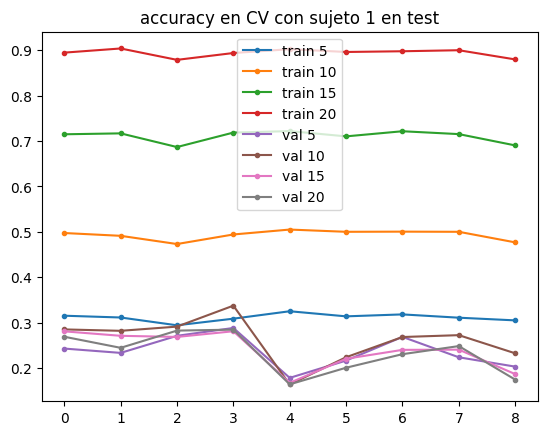

In [7]:
# el primer argumento controla la posicion de la grilla de hiperparametro
# el segundo controla el sujeto que miro
metricas_grilla[3][0].accuracy_train # hiperparametro posicion 3, sujeto posicion 0 (sujeto 1)

i = 0   # elijo el sujeto que saco para test
# Voy a graficar accuracy para las diferentes metricas
plt.figure()
plt.title('accuracy en CV con sujeto ' + str(i+1) + ' en test')
plt.plot(metricas_grilla[0][i].accuracy_train, '.-')
plt.plot(metricas_grilla[1][i].accuracy_train, '.-')
plt.plot(metricas_grilla[2][i].accuracy_train, '.-')
plt.plot(metricas_grilla[3][i].accuracy_train, '.-')

plt.plot(metricas_grilla[0][i].accuracy_val, '.-')
plt.plot(metricas_grilla[1][i].accuracy_val, '.-')
plt.plot(metricas_grilla[2][i].accuracy_val, '.-')
plt.plot(metricas_grilla[3][i].accuracy_val, '.-')

plt.legend(['train 5', 'train 10', 'train 15', 'train 20','val 5', 'val 10', 'val 15', 'val 20'])

# la mejor opcion parece max_depth=10

In [ ]:
# elijo el hiperparámetro óptimo en cada caso
params_opt = [10, 10, 10, 10, 5, 10, 10, 5, 10, 10]

# tenia mucha desviación max_depth=10, en el caso que eligi 5, igualmente 10 no seria mala eleccion

In [ ]:
folds_ind = joblib.load('folds_W200_I50_sujetoTest_' + str(1) + '.pkl')
sujetos_array = joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(2) + '.pkl')

print(folds_ind)

[array([], dtype=int64), array([   0,    1,    2, ..., 5555, 5556, 5557]), array([ 5558,  5559,  5560, ..., 12118, 12119, 12120]), array([12121, 12122, 12123, ..., 17671, 17672, 17673]), array([17674, 17675, 17676, ..., 24621, 24622, 24623]), array([24624, 24625, 24626, ..., 31115, 31116, 31117]), array([31118, 31119, 31120, ..., 37990, 37991, 37992]), array([37993, 37994, 37995, ..., 44782, 44783, 44784]), array([44785, 44786, 44787, ..., 51319, 51320, 51321]), array([51322, 51323, 51324, ..., 57842, 57843, 57844])]


In [ ]:
grilla_max_depth = [5, 10, 15, 20]
sujetos_array_lista = []
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"
for i in range(0, 10): # aca decido qué sujeto va para test
  # Importo particiones
  sujetos_array_lista.append(joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl'))   # lista con todos los sujetos, donde el primero corresponde al de test

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest


In [ ]:
nombre = 'HW_scaled_pca_DecisionTree_sep_sub_CV_1test'

joblib.dump(modelos_grilla, nombre + '.pkl')
joblib.dump(metricas_grilla, nombre + '_metricas.pkl')

API_KEY = 'ehXeElNypcj7Knar5zTmyjwSO'

exp = Experiment(api_key=API_KEY,
                project_name='tesis-experimentos', # Nombre del proyecto donde se registran los experimentos
                auto_param_logging=False)
exp.set_name(nombre) # Nombre de este experimento
exp.add_tags(['HelloWorld', 'standardScaler', 'pca', 'DecisionTree', 'sep_sub', 'choose_test', 'gridSearch', 'CV']) # Tags

exp.log_parameter("particion_sujetos", sujetos_array_lista)   # Guarda el arreglo en el experimento
exp.log_parameter("param_grid", grilla_max_depth)   # Guarda el arreglo en el experimento
exp.log_parameter("hiperparameter_name", 'max_depth')   # Guarda el arreglo en el experimento
exp.log_text("Se usó pca 0.98. Se fija el sujeto de test, para cada una de las 10 CV (de cada valor del hiperparámetro). Se hace una búsqueda del parámetro max_depth. El primer sujeto del arreglo de sujetos es el de test (para cada uno de los 10 experimentos, está en orden).")   # Comentario del experimento
exp.log_model(name=nombre, file_or_folder=nombre + '.pkl')
exp.log_model(name=nombre + '_metricas', file_or_folder=nombre + '_metricas.pkl')

exp.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/001fe9324e12472e8320d44349a97d83

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : HW_scaled_pca_DecisionTree_sep_sub_CV_1test
COMET INFO:     url                   : https://www.comet.com/manuelmolinach99/tesis-experimentos/001fe9324e12472e8320d44349a97d83
COMET INFO:   Others:
COMET INFO:     Name : HW_scaled_pca_Decisio

# Entrenamiento y resultados en test

In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"

full_pipeline = Pipeline([
    ('dt_classifier', DecisionTreeClassifier())
])

precision_train = []
accuracy_train = []
recall_train = []
precision_test = []
accuracy_test = []
recall_test = []
guardar_modelos = []
sujetos_test = []
for i in range(0, 10):
  folds_ind = joblib.load('folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl') # lista de listas. en cada elemento tengo la lista de indices de un fold
  sujetos_array = joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl')   # lista con todos los sujetos, donde el primero corresponde al de test
  sujetos_test.append(sujetos_array[0])
  # por el criterio elegido, se que el primer fold es para test, asi que lo saco
  fold_test = folds_ind[0]

  # ahora lo quito para no armar entrevero
  folds_ind = folds_ind[1:]

  # concateno los arrays de train_ind en uno solo
  folds_ind_train_array = np.concatenate(folds_ind)
  # aplanar el array resultante
  folds_ind_train_array = folds_ind_train_array.ravel()

  # Defino X_train, y_train, X_val, y_val
  X_train = features_array[folds_ind_train_array, :]
  y_train = label_array[folds_ind_train_array, 1]

  X_test = features_array[fold_test, :]
  y_test = label_array[fold_test, 1]

  full_pipeline.set_params(dt_classifier__max_depth=params_opt[i])
  full_pipeline.fit(X_train, y_train)

  # calculo las predicciones sobre los datos de train y val
  y_pred_train = full_pipeline.predict(X_train)
  y_pred_test = full_pipeline.predict(X_test)

  # calculo metricas sobre conjunto de train y val
  precision_train.append(precision_score(y_train, y_pred_train, average='weighted'))
  precision_test.append(precision_score(y_test, y_pred_test, average='weighted'))
  accuracy_train.append(accuracy_score(y_train, y_pred_train))
  accuracy_test.append(accuracy_score(y_test, y_pred_test))
  recall_train.append(recall_score(y_train, y_pred_train, average='weighted'))
  recall_test.append(recall_score(y_test, y_pred_test, average='weighted'))
  guardar_modelos.append(full_pipeline)



/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
joblib.dump(guardar_modelos, 'dt_HW_NP_10_sep_sub_max_depth_trainTest_modelos.pkl')

['dt_HW_NP_10_sep_sub_max_depth_trainTest_modelos.pkl']

In [ ]:
# Crear DataFrame
data = {'sujeto_test': sujetos_test,
        'precision_train': precision_train,
        'precision_test': precision_test,
        'accuracy_train': accuracy_train,
        'accuracy_test': accuracy_test,
        'recall_train': recall_train,
        'recall_test': recall_test}
data = pd.DataFrame(data)
joblib.dump(data, 'dt_HW_NP_10_sep_sub_max_depth_trainTest.pkl')

['dt_HW_NP_10_sep_sub_max_depth_trainTest.pkl']

In [ ]:
data.head(10)

,sujeto_test,precision_train,precision_test,accuracy_train,accuracy_test,recall_train,recall_test
0,0,0.567156,0.236751,0.485331,0.212846,0.485331,0.212846
1,1,0.529785,0.310688,0.472457,0.251867,0.472457,0.251867
2,2,0.555838,0.336551,0.484272,0.264362,0.484272,0.264362
3,3,0.543317,0.328323,0.479940,0.273957,0.479940,0.273957
4,4,0.544976,0.366577,0.472877,0.281491,0.472877,0.281491
5,5,0.554932,0.227088,0.473747,0.193455,0.473747,0.193455
6,6,0.536818,0.239435,0.477691,0.228946,0.477691,0.228946
7,7,0.397694,0.339687,0.300678,0.254551,0.300678,0.254551
8,8,0.542791,0.284999,0.497181,0.258163,0.497181,0.258163
9,9,0.530281,0.195172,0.475823,0.159108,0.475823,0.159108


In [ ]:
# Acceder a las metricas y modelos si los tengo guardados en un pkl
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/holaMundo/resultados_preliminares"

metricas_grilla = joblib.load("HW_NP_DecisionTree_sep_sub_10exp_1test_metricas.pkl")
modelos_grilla = joblib.load("HW_NP_DecisionTree_sep_sub_10exp_1test.pkl")

print(modelos_grilla)

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/holaMundo/resultados_preliminares
[Pipeline(steps=[('dt_classifier', DecisionTreeClassifier(max_depth=10))]), Pipeline(steps=[('dt_classifier', DecisionTreeClassifier(max_depth=10))]), Pipeline(steps=[('dt_classifier', DecisionTreeClassifier(max_depth=10))]), Pipeline(steps=[('dt_classifier', DecisionTreeClassifier(max_depth=10))]), Pipeline(steps=[('dt_classifier', DecisionTreeClassifier(max_depth=10))]), Pipeline(steps=[('dt_classifier', DecisionTreeClassifier(max_depth=10))]), Pipeline(steps=[('dt_classifier', DecisionTreeClassifier(max_depth=10))]), Pipeline(steps=[('dt_classifier', DecisionTreeClassifier(max_depth=10))]), Pipeline(steps=[('dt_classifier', DecisionTreeClassifier(max_depth=10))]), Pipeline(steps=[('dt_classifier', DecisionTreeClassifier(max_depth=10))])]


In [ ]:
params_opt = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
sujetos_array_lista = []
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"
for i in range(0, 10): # aca decido qué sujeto va para test
  # Importo particiones
  sujetos_array_lista.append(joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl'))   # lista con todos los sujetos, donde el primero corresponde al de test

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest


In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/holaMundo/resultados_preliminares"

nombre = 'HW_NP_DecisionTree_sep_sub_10exp_1test'

joblib.dump(modelos_grilla, nombre + '.pkl')
joblib.dump(metricas_grilla, nombre + '_metricas.pkl')

API_KEY = 'ehXeElNypcj7Knar5zTmyjwSO'

exp = Experiment(api_key=API_KEY,
                project_name='tesis-experimentos', # Nombre del proyecto donde se registran los experimentos
                auto_param_logging=False)
exp.set_name(nombre) # Nombre de este experimento
exp.add_tags(['HelloWorld', 'DecisionTree', 'sep_sub', 'choose_test']) # Tags

exp.log_parameter("particion_sujetos", sujetos_array_lista)   # Guarda el arreglo en el experimento
exp.log_parameter("hiparams_usados", params_opt)   # Guarda el arreglo en el experimento
exp.log_parameter("hiperparameter_name", 'max_depth')   # Guarda el arreglo en el experimento
exp.log_text("Se guardan los modelos y metricas de 10 experimentos. En cada uno se usa la partición de particion_sujetos y el hiperparametro de hiparams_usados. Se fija el sujeto de test, siendo el primero del arreglo.")   # Comentario del experimento
exp.log_model(name=nombre, file_or_folder=nombre + '.pkl')
exp.log_model(name=nombre + '_metricas', file_or_folder=nombre + '_metricas.pkl')

exp.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/holaMundo/resultados_preliminares


COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/a998fca6e2d746cc994ea4084bd45e93

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : HW_NP_DecisionTree_sep_sub_10exp_1test
COMET INFO:     url                   : https://www.comet.com/manuelmolinach99/tesis-experimentos/a998fca6e2d746cc994ea4084bd45e93
COMET INFO:   Others:
COMET INFO:     Name : HW_NP_DecisionTree_sep_sub_10exp_1test
COMET INFO:   Parameters:
COMET INFO:     hiparams_usados     : [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
COMET INFO:     hiperparameter_name : max_depth
COMET INFO:     particion_sujetos   : [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 0, 2, 3, 4, 5, 6, 7, 8, 9], [2, 0, 1, 3,